In [97]:
# Importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
# importing stats libraries
import statsmodels.api as sm
plt.style.use('seaborn-poster')

In [98]:
# Reading the data
data = pd.read_excel(r'D:\Asha\Imp\ML\Data\TimeSeries_Superstore.xls')

In [99]:
# checking shape of data
print('Shape of Data: ',data.shape)
# Check columns
print (data.columns)
# Checking Categories
print ('Categories :',data.Category.unique())

Shape of Data:  (9994, 21)
Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')
Categories : ['Furniture' 'Office Supplies' 'Technology']


In [100]:
# **************************Time Series Analyis for Furniture Sales******************************
# Filtering dataset of furniture sales
furniture_data = data[data['Category'] == 'Furniture']
# Checking the Furniture orders (or sales) 
print('Range: ',furniture_data['Order Date'].min(),furniture_data['Order Date'].max()) # 4 years of data available

# Data preprocessing : This step includes checkign for missing values, dropping unwanted columns, aggegating and reindexing 
# with the date column.

# Checing for missing values
furniture_data.isnull().sum() # No Missing Values

# Dropping the columns that are not needed for this analysis
columns = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 
                                      'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 
                                      'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture = furniture_data.drop(columns,axis = 1)

# Aggregating the Sales by Date
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

# Indexing with Date column
furniture = furniture.set_index('Order Date')

Range:  2014-01-06 00:00:00 2017-12-30 00:00:00


In [174]:
# taking the mean daily sales for the start of the month (MS for month start). 
furniture_sales = furniture['Sales'].resample('MS').mean()


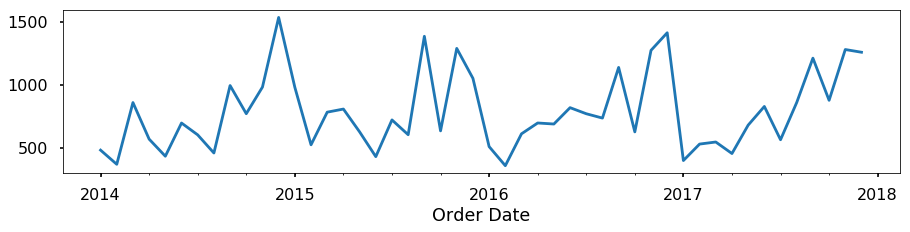

In [175]:
furniture_sales.plot(figsize=(15, 3))
plt.show()

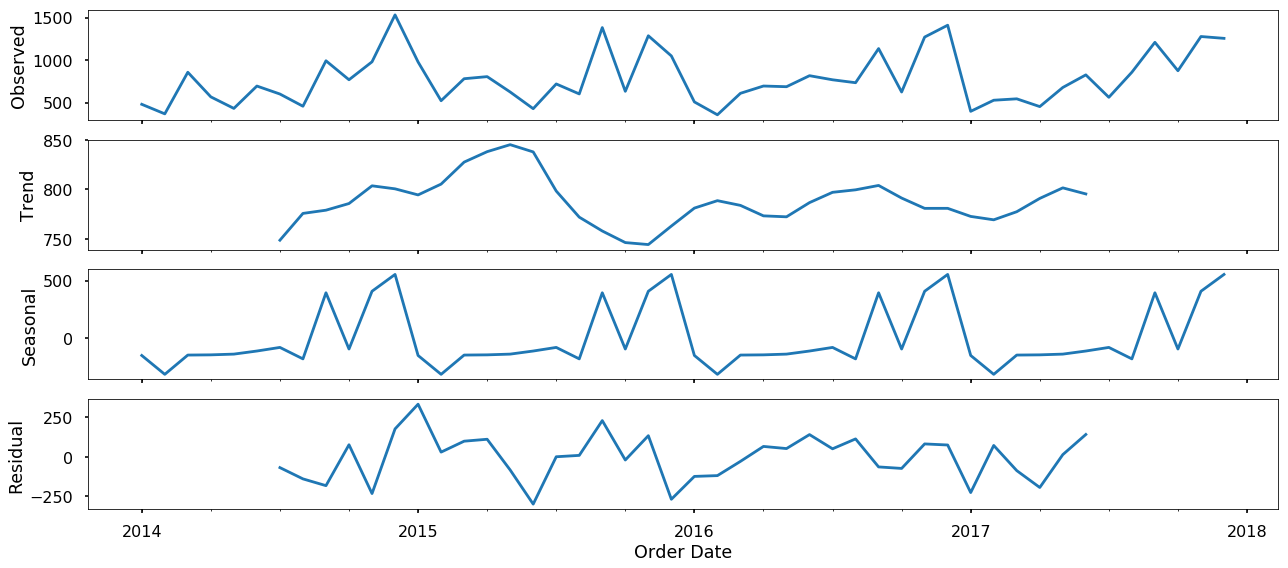

In [176]:
#Using time-series decomposition to decompose the time series into three distinct components: trend, seasonality, and noise.
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(furniture_sales, model='additive')
fig = decomposition.plot()
plt.show()

In [177]:
# By checking the decomposed charts it seems that the series has trend and seasonality. Confirming with Dicky Fuller test
# Function for Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() #pd.rolling_mean(timeseries, window=12)
    rolstd = timeseries.rolling(12).std()#pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

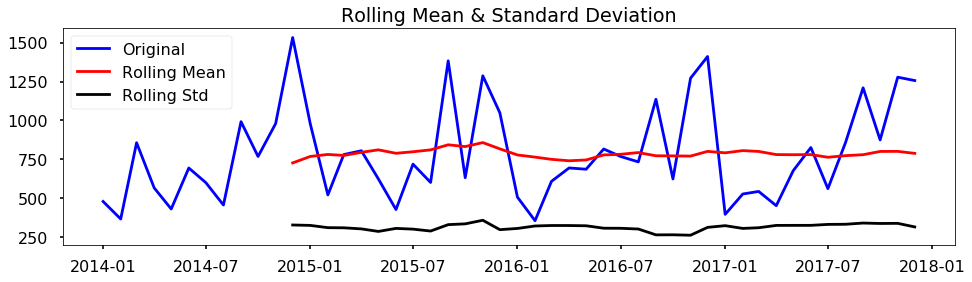

Results of Dickey-Fuller Test:
Test Statistic                 -5.191070
p-value                         0.000009
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


In [178]:
# Test signifies that the series is not stationary 
# Note:If the ‘Test Statistic’ is greater than the ‘Critical Value’ then the time series is considered as stationary
test_stationarity(furniture_sales)

In [180]:
# ********************Forcasting with ARIMA**********************
# For choosing optimal set of parameters, using Grid Search
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(furniture_sales,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1411.6337751593537
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309202774
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1381.1677821470485
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758122
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3277.190348269657
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091573
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5984079804132
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2624.89660993016
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468685
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766859465
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1205.7180469024538
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785671879367
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1581.293187405543
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109212
ARI

In [181]:
# ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.78754395474436 prvides the best AIC. So, choosing this set
# Fitting the ARIMA Model
mod = sm.tsa.statespace.SARIMAX(furniture_sales,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -144.894
Date:                            Sun, 09 Dec 2018   AIC                            297.788
Time:                                    18:07:06   BIC                            302.152
Sample:                                01-01-2014   HQIC                           298.816
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360   

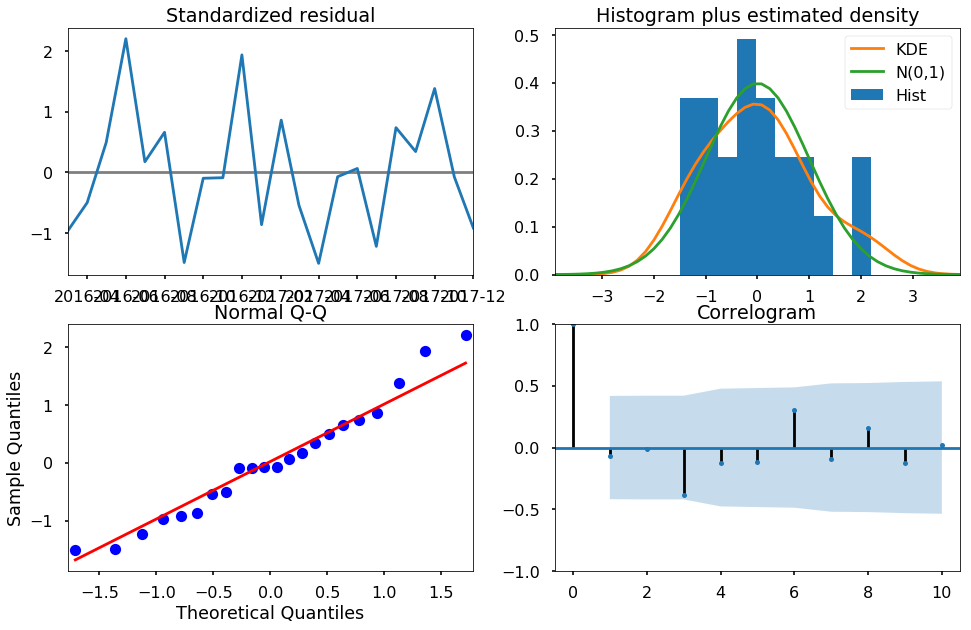

In [184]:
# running model diagnostics to investigate any unusual behavior
results.plot_diagnostics(figsize=(16, 10))
plt.show()

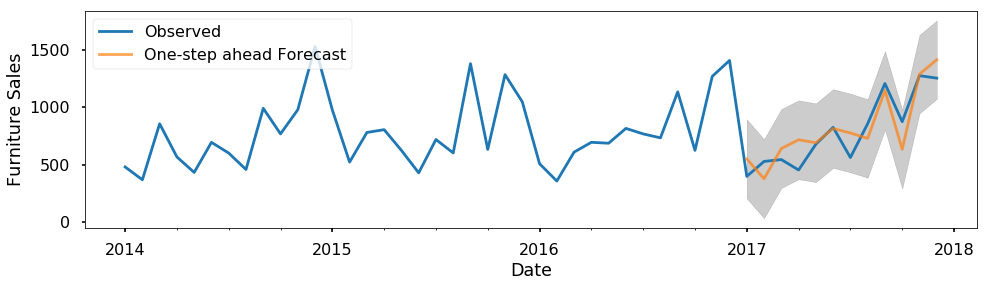

In [185]:
# Validating Forecasts
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = furniture_sales['2014':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(16, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [186]:
# MSE for the Forecast
furniture_sales_forecasted = pred.predicted_mean
furniture_sales_truth = furniture_sales['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))
print('RMSE {}'.format(round(np.sqrt(mse), 2)))
# RMSE tells that model was able to forecast the average daily furniture sales in the test 
#set within 151.64 of the real sales. 

MSE 22993.58
RMSE 151.64


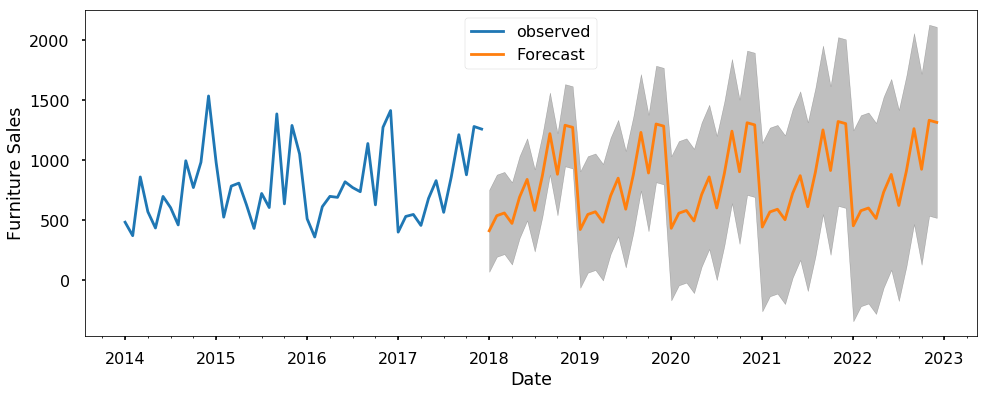

In [195]:
# Predicting for next 5 years
pred_uc = results.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()
ax = furniture_sales.plot(label='observed', figsize=(16, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
legend = ax.legend(loc='upper center')

plt.show()